In [ ]:
!add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree

!pip install rasterio
!pip install geopandas
!pip install descartes
!pip install solaris
!pip install rio-tiler

In [ ]:
#!pip install solaris==0.2.1
!pip install git+https://github.com/CosmiQ/solaris/@dev

In [ ]:
# restarts runtime
import os
os._exit(00)

In [1]:
import solaris as sol
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
%cd /content/drive/'My Drive'/GEE/newimp

/content/drive/.shortcut-targets-by-id/1-xIvf506_kb2yNUdqXW9KR1dineJd7Vh/GEE/newimp


In [4]:
rasterio.open('Rajsthan_image_1.tif').meta

{'count': 3,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 3486,
 'nodata': None,
 'transform': Affine(8.983152841195215e-05, 0.0, 72.81608945780224,
       0.0, -8.983152841195215e-05, 26.804200942143517),
 'width': 2126}

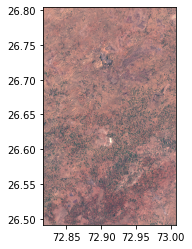

In [5]:
#Loading the Raster image extracted from Google Earth Engine
from rasterio.plot import show
src = rasterio.open('Rajsthan_image_1.tif')
show(src)


In [6]:
label_df = gpd.read_file('Rajasthan_solar_1.geojson')
label_df = label_df[label_df['geometry'].isna() != True]

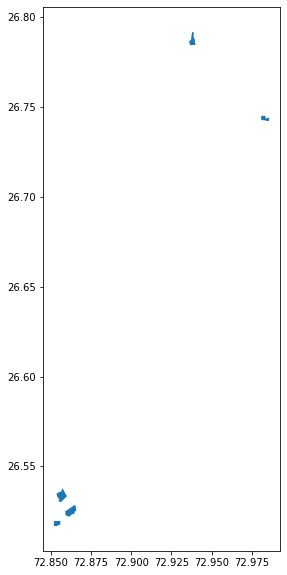

In [7]:
#Plotting the Sand Dunes Geometries using GeoDataFrame Object
label_df.plot(figsize=(10, 10))

In [8]:
#Setting up the size of the tiles to be generated from the Raster and Geometries. Also the zoom level at which the tiling will take place.
tile_size = 256
zoom_level = 15

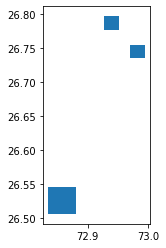

In [9]:
#Plotting the Areas of Interests (used for splitting the dataset into train and val sets)
aoi_df = gpd.read_file('AOI-1.geojson')
aoi_df.plot()

In [10]:
#Dividing the AoI Geometries into Train Set and Val set based on their metadata property 'dataset'
aoi_df[aoi_df['dataset']=='trn']['geometry'].to_file('trn_aoi.geojson', driver='GeoJSON')
#aoi_df[aoi_df['dataset']=='val']['geometry'].to_file('val_aoi.geojson', driver='GeoJSON')

In [11]:
#Splitting the Val & Train AOIs into small tiles based on the tile size and zoom level using Supermercado
!pip install supermercado
!cat trn_aoi.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > trn_aoi_z{zoom_level}tiles.geojson

  Created wheel for supermercado: filename=supermercado-0.0.5-cp36-none-any.whl size=7087 sha256=5b8f65ba0def3ea05d145cc9dcbbf7cfd75d6d3393226231f971176c0f642c7b
  Stored in directory: /root/.cache/pip/wheels/9b/2f/8e/011d7ab17b423894b4b358204c0bb854a8bb8de199e9f98f30
Successfully built supermercado


In [12]:
trn_tiles = gpd.read_file(f'trn_aoi_z{zoom_level}tiles.geojson')
#val_tiles = gpd.read_file(f'val_aoi_z{zoom_level}tiles.geojson')
trn_tiles['dataset'] = 'trn'
#val_tiles['dataset'] = 'val'

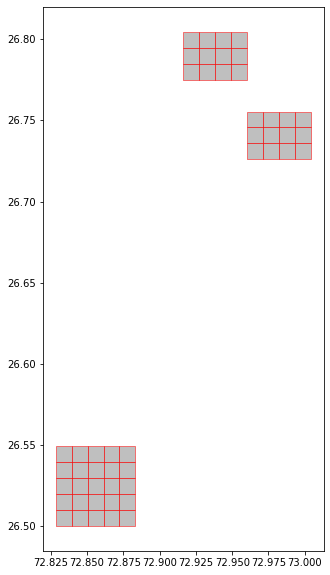

In [13]:
# Plotting the AoIs which have now been split into small tiles. The given image has train AoI tiles only.
fig, ax = plt.subplots(figsize=(10,10))
trn_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='red')
#val_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='blue')

In [14]:
#This Kernel checks if there are any overlapping tiles between train and val. If there are, all overlapping tiles are assigned to the train set.
import pandas as pd
tiles_gdf = gpd.GeoDataFrame(pd.concat([trn_tiles], ignore_index=True), crs=trn_tiles.crs)
tiles_gdf.drop_duplicates(subset=['id'], inplace=True)

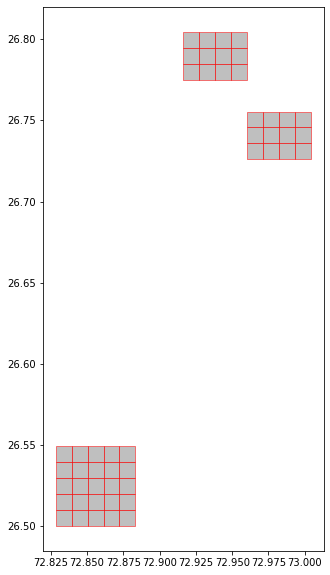

In [15]:
#Plotting the processed tiled AoI geometry
fig, ax = plt.subplots(figsize=(10,10))
tiles_gdf[tiles_gdf['dataset'] == 'trn'].plot(ax=ax, color='grey', edgecolor='red', alpha=0.5)
#tiles_gdf[tiles_gdf['dataset'] == 'val'].plot(ax=ax, color='grey', edgecolor='blue', alpha=0.5) 

In [16]:
#Reviewing the first 5 data entries of the tiled AoI geometry, Consists of Geometries and position coordinates of the tiles.
tiles_gdf.head()

,id,title,geometry,dataset
0,"(23021, 13850, 15)","XYZ tile (23021, 13850, 15)","POLYGON ((72.91626 26.79465, 72.91626 26.80446...",trn
1,"(23022, 13850, 15)","XYZ tile (23022, 13850, 15)","POLYGON ((72.92725 26.79465, 72.92725 26.80446...",trn
2,"(23023, 13850, 15)","XYZ tile (23023, 13850, 15)","POLYGON ((72.93823 26.79465, 72.93823 26.80446...",trn
3,"(23024, 13850, 15)","XYZ tile (23024, 13850, 15)","POLYGON ((72.94922 26.79465, 72.94922 26.80446...",trn
4,"(23021, 13851, 15)","XYZ tile (23021, 13851, 15)","POLYGON ((72.91626 26.78485, 72.91626 26.79465...",trn


In [17]:
#Modifying the table to include one more column 'xyz' for explicitly assigning the position coordinates of the tiles.
#X and Y correspond to the 2D locations, Z represents the zoom level at which tiling took place
def reformat_xyz(tile_gdf):
  tile_gdf['xyz'] = tile_gdf.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tile_gdf['xyz'] = [[int(q) for q in p] for p in tile_gdf['xyz']]
  return tile_gdf

tiles_gdf = reformat_xyz(tiles_gdf)
tiles_gdf.head()

,id,title,geometry,dataset,xyz
0,"(23021, 13850, 15)","XYZ tile (23021, 13850, 15)","POLYGON ((72.91626 26.79465, 72.91626 26.80446...",trn,"[23021, 13850, 15]"
1,"(23022, 13850, 15)","XYZ tile (23022, 13850, 15)","POLYGON ((72.92725 26.79465, 72.92725 26.80446...",trn,"[23022, 13850, 15]"
2,"(23023, 13850, 15)","XYZ tile (23023, 13850, 15)","POLYGON ((72.93823 26.79465, 72.93823 26.80446...",trn,"[23023, 13850, 15]"
3,"(23024, 13850, 15)","XYZ tile (23024, 13850, 15)","POLYGON ((72.94922 26.79465, 72.94922 26.80446...",trn,"[23024, 13850, 15]"
4,"(23021, 13851, 15)","XYZ tile (23021, 13851, 15)","POLYGON ((72.91626 26.78485, 72.91626 26.79465...",trn,"[23021, 13851, 15]"


In [18]:
from rio_tiler import main as rt_main
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

In [19]:
#Arbitrary selecting any one tile from the AoI geometry to test the subsequent process
idx = 41
tiles_gdf.iloc[idx]['xyz']

[23015, 13879, 15]

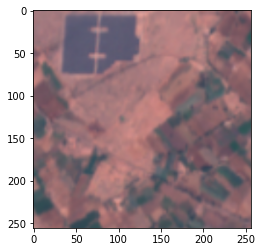

In [20]:
#Extracting the same tile from the TIFF image as that selected from the AoI. Basically, the AoI tiles act as reference for splitting the TIFF images and GeoJS
tile, mask = rt_main.tile('Rajsthan_image_1.tif', *tiles_gdf.iloc[idx]['xyz'], tilesize=tile_size)
plt.imshow(np.moveaxis(tile,0,2))

In [21]:
all_polys = label_df.geometry

In [22]:
# preemptively fixing and merging any invalid or overlapping geoms that would otherwise throw errors during the rasterize step. 

def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

def cleanup_invalid_geoms(all_polys):
  all_polys_merged = gpd.GeoDataFrame()
  all_polys_merged['geometry'] = gpd.GeoSeries(cascaded_union([p.buffer(0) for p in all_polys]))

  gdf_out = explode(all_polys_merged)
  gdf_out = gdf_out.reset_index()
  gdf_out.drop(columns=['level_0','level_1'], inplace=True)
  all_polys = gdf_out['geometry']
  return all_polys

all_polys = cleanup_invalid_geoms(all_polys)

41
(72.850341796875, 26.50990453141392, 72.861328125, 26.51973530566078)


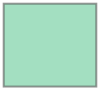

In [23]:
#getting the same tile polygon from the Solar Farm geomtry as our tile image above (again using the same AoI tile as reference)
tile_poly = tiles_gdf.iloc[idx]['geometry']
print(idx)
print(tile_poly.bounds)
tile_poly

In [24]:
# get affine transformation matrix for this tile using rasterio.transform.from_bounds: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds
tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
tfm

Affine(4.291534423828125e-05, 0.0, 72.850341796875,
       0.0, -3.8401461901801937e-05, 26.51973530566078)

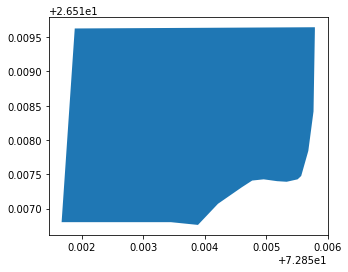

In [25]:
#crop Solar Farm geometries to what overlaps our AoI tile polygon bounds
cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
cropped_polys_gdf.plot()

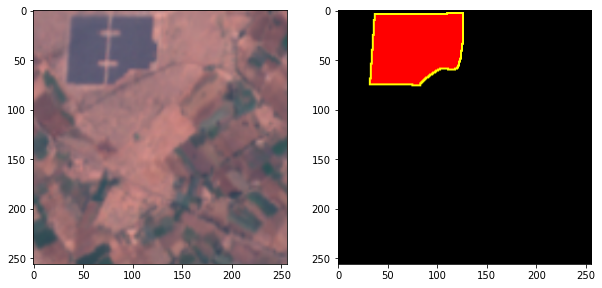

In [26]:
# burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html
fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(np.moveaxis(tile,0,2))
ax2.imshow(fbc_mask)

In [27]:
#BUILDING the Complete Dataset, by iteratively applying the same procedure to all the images.

data_dir = Path('data-sd-3')
data_dir.mkdir(exist_ok=True)

img_path = data_dir/'images-256'
mask_path = data_dir/'masks-256'
img_path.mkdir(exist_ok=True)
mask_path.mkdir(exist_ok=True)

import skimage
from tqdm import tqdm

def save_tile_img(tif_url, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tile, mask = rt_main.tile(tif_url, x,y,z, tilesize=tile_size)
  if display: 
    plt.imshow(np.moveaxis(tile,0,2))
    plt.show()
    
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.png',np.moveaxis(tile,0,2), check_contrast=False) 

def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
  
  cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
  cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
  
  fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
  if display: plt.imshow(fbc_mask); plt.show()
  
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask, check_contrast=False)  

In [28]:
tiles_gdf[tiles_gdf['dataset'] == 'trn'].shape#, tiles_gdf[tiles_gdf['dataset'] == 'val'].shape

(49, 5)

In [29]:

for idx, tile in tqdm(tiles_gdf.iterrows()):
  dataset = tile['dataset']
  save_tile_img('Rajsthan_image_1.tif', tile['xyz'], tile_size, save_path=img_path, prefix=f'sd{dataset}_', display=False)

49it [00:48,  1.02it/s]


In [ ]:
# TODO: multiprocess this? Took ~3 mins to burn and save 1261 masks
for idx, tile in tqdm(tiles_gdf.iterrows()):
  dataset = tile['dataset']
  tile_poly = tile['geometry']
  save_tile_mask(all_polys, tile_poly, tile['xyz'], tile_size, save_path=mask_path,prefix=f'sd{dataset}_', display=False)

6it [00:04,  1.14it/s]